# First steps on fitting SITELLE's spectra (with ORB)

##  A few words on ORCS/ORB architecture

You can see this paper for more informations: [Martin et al. 2015](https://www.researchgate.net/publication/285581562_ORBS_ORCS_OACS_a_Software_Suite_for_Data_Reduction_and_Analysis_of_the_Hyperspectral_Imagers_SITELLE_and_SpIOMM)

* ORB is the core library of SITELLE
* ORCS is a wrapper around ORB's libraries which provides higher level (easier) methods for reduced spectral cubes. But all the basic work can be done with ORB.

## Fitting a simulated Fourier spectrum (with ORB)

In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import scipy
import orb.utils.sim
import orb.fit
import gvar

/home/thomas/Astro/Python/ORB/Orb/orb/fit.py:129: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vector = gvar.mean(np.copy(vector))
/home/thomas/Astro/Python/ORB/Orb/orb/fit.py:142: UserWarning: No SNR guess given. Fit mode is classic.
  warnings.warn('No SNR guess given. Fit mode is classic.')


h: 0.222(52)
a: 100.3(1.0)
dx: 80.1020803943
fwhm: 1.20925(91)


/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(60.099999999999994, 100.1)

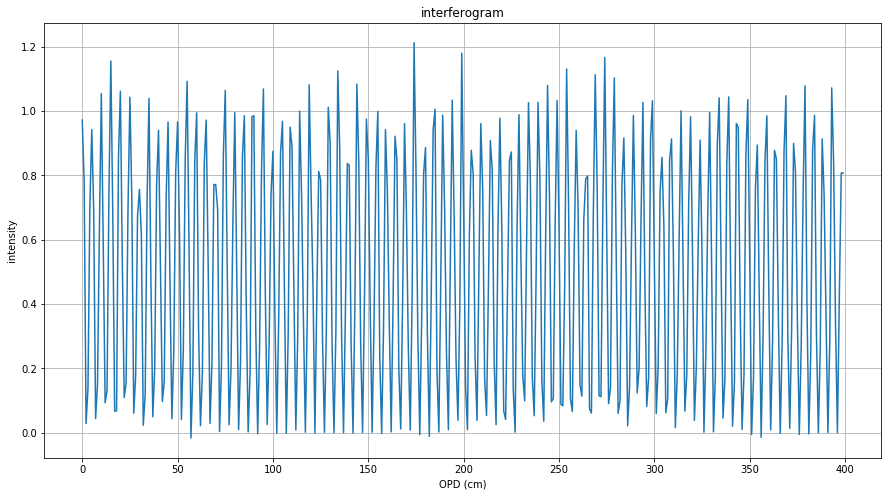

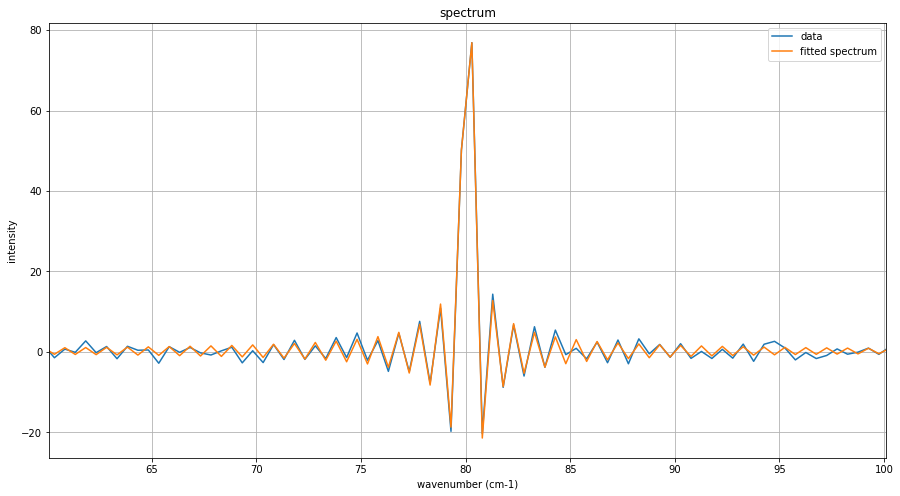

In [2]:
#  simulate interferogram
sigma = 80.1
step_nb = 400
interf = orb.utils.sim.line_interf(sigma, step_nb)
interf += np.random.standard_normal(interf.size) * np.sqrt(interf) * 0.1 # photon noise

pl.figure(figsize=(15,8))
pl.plot(interf)
pl.grid()
pl.title('interferogram')
pl.xlabel('OPD (cm)')
pl.ylabel('intensity')

# simulate spectrum
axis, spectrum = orb.utils.sim.fft(interf, zp_coeff=1)
faxis = scipy.interpolate.interp1d(np.arange(axis.size), axis)

# fit spectrum
fit = orb.fit.fit_lines_in_vector(
    spectrum, [161.], 1.20671, fmodel='sinc', fwhm_def='free')

p = fit['lines_params_gvar']
print 'h: {}'.format(p[0][0])
print 'a: {}'.format(p[0][1])
print 'dx: {}'.format(faxis(gvar.mean(p[0][2])))
print 'fwhm: {}'.format(p[0][3])


pl.figure(figsize=(15, 8))
pl.plot(axis, spectrum, label='data')
pl.plot(axis, fit['fitted_vector'], label='fitted spectrum')
pl.legend()
pl.grid()
pl.title('spectrum')
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('intensity')
pl.xlim([sigma-20, sigma+20])


## fitting under-resolved lines

(70.1, 90.1)

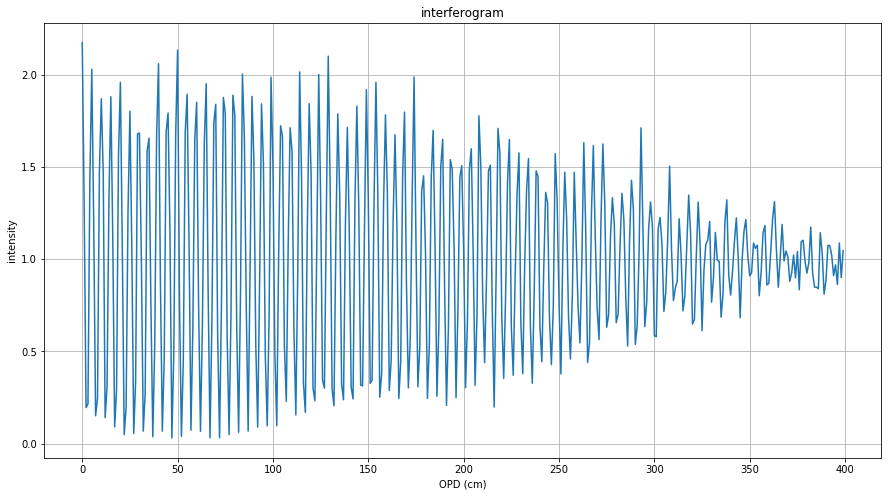

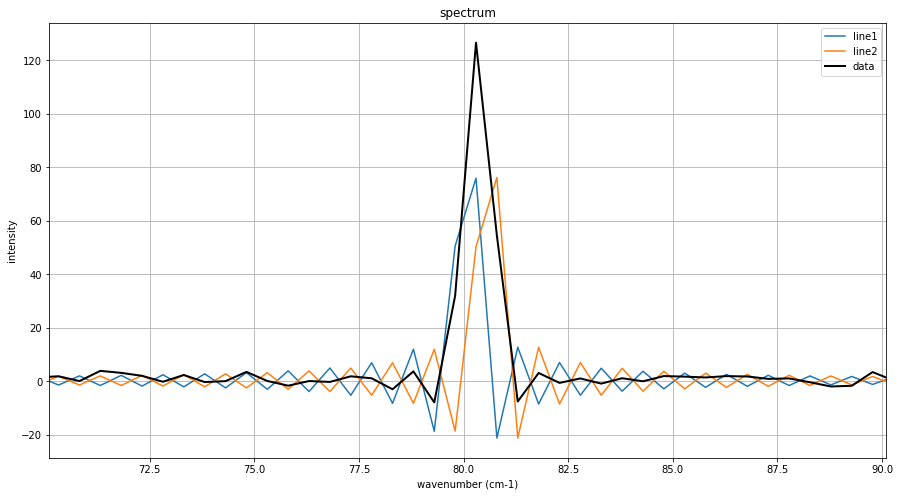

In [4]:
#  simulate interferogram
sigma = 80.1
sigma2 = 80.6
step_nb = 400
iline1 = orb.utils.sim.line_interf(sigma, step_nb)
iline2 = orb.utils.sim.line_interf(sigma2, step_nb)
interf = iline1 + iline2
noise = np.random.standard_normal(interf.size) * np.sqrt(interf) * 0.1 # photon noise
interf += noise

pl.figure(figsize=(15,8))
pl.plot(interf)
pl.grid()
pl.title('interferogram')
pl.xlabel('OPD (cm)')
pl.ylabel('intensity')

# simulate spectrum
axis, spectrum = orb.utils.sim.fft(interf, zp_coeff=1)
axis, line1 = orb.utils.sim.fft(iline1, zp_coeff=1)
axis, line2 = orb.utils.sim.fft(iline2, zp_coeff=1)


pl.figure(figsize=(15, 8))

pl.plot(axis, line1, label='line1')
pl.plot(axis, line2, label='line2')
pl.plot(axis, spectrum, label='data', lw=2., c='black')

pl.legend()
pl.grid()
pl.title('spectrum')
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('intensity')
pl.xlim([sigma-10, sigma+10])

### two lines model

a: 99.3(1.1), 99.3(1.1)
dx: 80.0962494507, 80.5936048574
fwhm: 1.20671(0), 1.20671(0)


(70.1, 90.1)

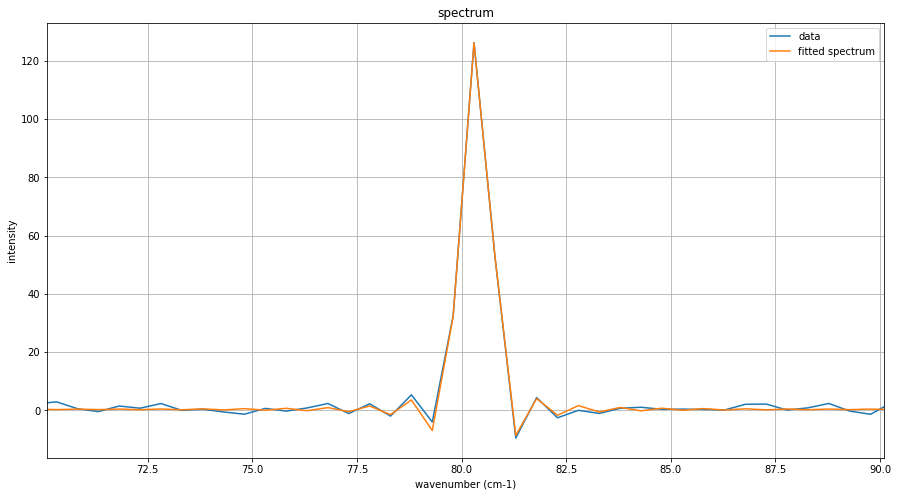

In [35]:
#  simulate interferogram
sigma = 80.1
sigma2 = 80.6
step_nb = 400
iline1 = orb.utils.sim.line_interf(sigma, step_nb)
iline2 = orb.utils.sim.line_interf(sigma2, step_nb)
interf = iline1 + iline2
noise = np.random.standard_normal(interf.size) * np.sqrt(interf) * 0.1 # photon noise
interf += noise

axis, spectrum = orb.utils.sim.fft(interf, zp_coeff=1)
faxis = scipy.interpolate.interp1d(np.arange(axis.size), axis)

# fit spectrum
fit = orb.fit.fit_lines_in_vector(
    spectrum, [sigma*2, sigma2*2], 
    1.20671, fmodel='sinc', 
    fwhm_def='fixed', # fwhm must be fixed or at least covarying. But this is a known quantity in a Fourier spectrum
    amp_def=['1', '1'],
    amp_guess=[1,1]) 

p = fit['lines_params_gvar']
print 'a: {}, {}'.format(p[0][1], p[1][1])
print 'dx: {}, {}'.format(faxis(gvar.mean(p[0][2])), faxis(gvar.mean(p[1][2])))
print 'fwhm: {}, {}'.format(p[0][3], p[1][3])


pl.figure(figsize=(15, 8))
pl.plot(axis, spectrum, label='data')
pl.plot(axis, fit['fitted_vector'], label='fitted spectrum')
pl.legend()
pl.grid()
pl.title('spectrum')
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('intensity')
pl.xlim([sigma-10, sigma+10])

## overfitting

In general underfitting is easy to detect but overfitting can be tricky. One can be happy to perfectly fit the data but don't forget the noise !


a: 60.9(6.0), 60.9(6.0)
dx: 80.2367503196, 80.399698564
fwhm: 1.20671(0), 1.20671(0)


(70.1, 90.1)

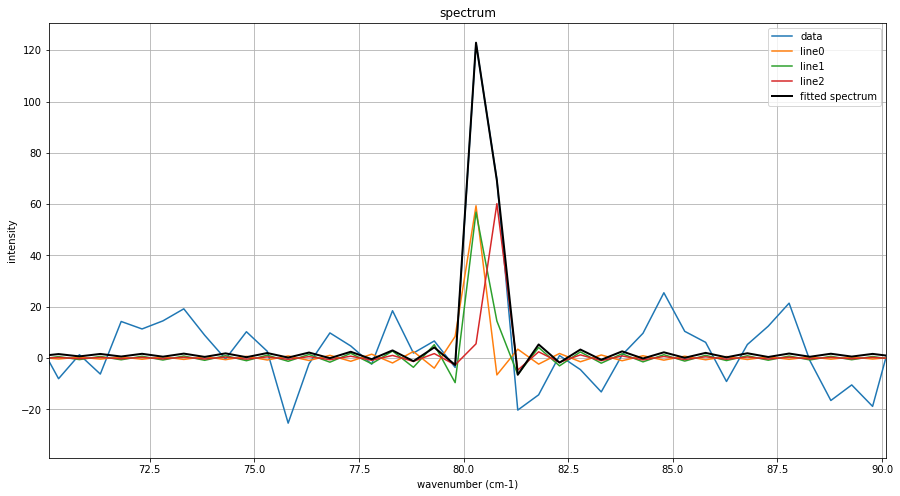

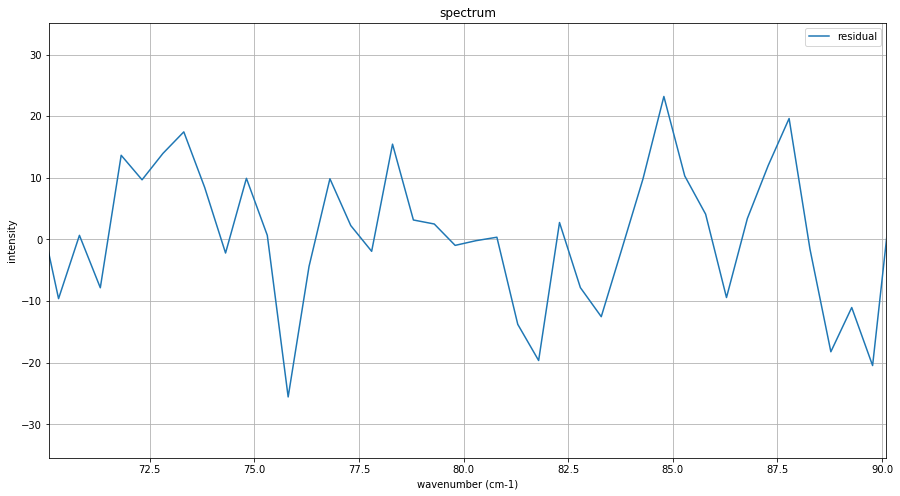

In [5]:
#  simulate interferogram
sigma = 80.1
sigma2 = 80.6
step_nb = 400
iline1 = orb.utils.sim.line_interf(sigma, step_nb)
iline2 = orb.utils.sim.line_interf(sigma2, step_nb)
interf = iline1 + iline2
noise = np.random.standard_normal(interf.size) * np.sqrt(interf) * 0.8 # photon noise
interf += noise

axis, spectrum = orb.utils.sim.fft(interf, zp_coeff=1)
faxis = scipy.interpolate.interp1d(np.arange(axis.size), axis)

# fit spectrum
fit = orb.fit.fit_lines_in_vector(
    spectrum, [sigma*2, sigma2*2, sigma2*2+0.1], 
    1.20671, fmodel='sinc', 
    fwhm_def='fixed', # fwhm must be fixed or at least covarying. But this is a known quantity in a Fourier spectrum
    amp_def=['1', '1', '1'],
    amp_guess=[1,1,1]) 

print 

p = fit['lines_params_gvar']
print 'a: {}, {}'.format(p[0][1], p[1][1])
print 'dx: {}, {}'.format(faxis(gvar.mean(p[0][2])), faxis(gvar.mean(p[1][2])))
print 'fwhm: {}, {}'.format(p[0][3], p[1][3])


pl.figure(figsize=(15, 8))
pl.plot(axis, spectrum, label='data')
for iline in range(len(fit['fitted_models']['LinesModel'])):
    pl.plot(axis, fit['fitted_models']['LinesModel'][iline], label='line{}'.format(iline))
pl.plot(axis, fit['fitted_vector'], label='fitted spectrum', lw=2, c='0.')
pl.legend()
pl.grid()
pl.title('spectrum')
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('intensity')
pl.xlim([sigma-10, sigma+10])

# plot residual
pl.figure(figsize=(15, 8))

pl.plot(axis, spectrum - fit['fitted_vector'], label='residual')

pl.grid()
pl.legend()
pl.title('spectrum')
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('intensity')
pl.xlim([sigma-10, sigma+10])
